# Dynamic Land Cover (dylancov) micro-service (2020-10-06)

In [1]:
from owslib.wps import WebProcessingService
wps = WebProcessingService('https://api.dylancov.bccvl.org.au/wps', verbose=False, skip_caps=True)
wps.getcapabilities()
wps.identification.type

'WPS'

In [2]:
wps.identification.title

'PyWPS Processing Service'

In [3]:
wps.identification.abstract

'PyWPS is an implementation of the Web Processing Service standard from the Open Geospatial Consortium. PyWPS is written in Python.'

In [4]:
for operation in wps.operations:
    print(operation.name)

GetCapabilities
DescribeProcess
Execute


## What processes are supported?

In [5]:
for process in wps.processes:
    print("{:>30}: {}".format(process.identifier, process.title))

               one_wps_process: Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections.


## Getting Process Descriptions

In [6]:
from owslib.wps import printInputOutput
process = wps.describeprocess('one_wps_process')
process.identifier

'one_wps_process'

In [7]:
process.title

'Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections.'

In [8]:
process.abstract

"Single entry point for all of dylancov's functions."

In [9]:
for input in process.dataInputs:
    printInputOutput(input)
    print()

 identifier=spatial_selection_type, title=Type of selection in space, abstract=None, data type=string
 Allowed Value: rectangular_region
 Allowed Value: single_location
 Allowed Value: predefined_region
 Allowed Value: polygon
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=time_selection_type, title=Type of selection in time, abstract=None, data type=string
 Allowed Value: one_year
 Allowed Value: years
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=categories, title=Categories to extract, abstract=None, data type=string
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=year, title=Year to process, in range 2002:2014, abstract=None, data type=integer
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=year_min, title=Year to process from, in range 2002:2014, abstract=None, data type=integer
 Default Value: None 
 minOccurs=0, maxOccurs=1

 identifier=year_max, title=Year to process to, in range 2002:2014, abstract=None, data type=integer


In [10]:
for output in process.processOutputs:
    printInputOutput(output)

 identifier=output, title=Metadata, abstract=None, data type=ComplexData
 Supported Value: mimeType=application/zip, encoding=None, schema=None
 Default Value: mimeType=application/zip, encoding=None, schema=None 
 reference=None, mimeType=None


## Understanding Dylancov's Unified WPS API

Dylancov's access is through one WPS API process. 
 It is identified by the processid `one_wps_process`.

Next, you need to specify a list of  `categories`, integer numbers from 1 to 35.

We have 4 types of spatial selections, and 2 types of time selections ( 4 x 2 = 8 combinations). Each have related parameters that must be specified.

To specify a spatial selection, you use the parameter `spatial_selection_type`. The options are: `rectangular_region`, `predefined_region`, `single_location`, `polygon`.

|Spatial Selection Type|Associated Parameters|
|-----------------|--------------------|
|rectangular_region|lat_min, lat_max, lon_min, lon_max|
|single_location|lat, lon|
|predefined_region|gdb_name, rec_id|
|polygon|geometry|

If you choose the `single_location`, for example, then you need to specify the variables `lat` and `lon`, as shown above.

To specify a time selection, you use the parameter `time_selection_type`. It may take one of the following 2 values:

|Time Selection Type|Associated Parameters|
|-----------------|--------------------|
|one_year|year|
|years|year_min, year_max|

If you choose the `years` type, for example, then additionally, you need to specify the variables `year_min` and `year_max`, as shown above.

## Execute a Rectangular Region Selection

Before we submit a process for execution, lets define a function to allow us to monitor the execution.

In [11]:
def monitor_execution(execution, sleepSecs=5, download=False, filepath='data/out.zip'):
    while execution.isComplete() is False:
        execution.checkStatus(sleepSecs=sleepSecs)
        print('Execution status: {}'.format(execution.statusMessage))

    if execution.isSucceded():
        if download:
            execution.getOutput(filepath=filepath)
        else:
            for output in execution.processOutputs:
                if output.reference is not None:
                    print('Output URL={}'.format(output.reference))
    else:
        for ex in execution.errors:
            print('Error: code={}, locator={}, text={}'.format(ex.code, ex.locator, ex.text))

The parameters are the following:
- `execution`: the wps process we submitted
- `sleepSecs`: how often to report the status (in seconds)
- `download`: if we want to download the result, then use `filepath`; otherwise, report a URL.
- `filepath`: path to where we want to store the result

If the execution terminated with errors, they will be listed. 

### Request a list of Categories

Since the Dynamic Land Cover micro-service uses `categorical` data, 
that is, numbers that represent categories, 
we need to get a list of the categories supported.

In [12]:
import requests
import json

response = requests.get("https://api.dylancov.bccvl.org.au/categories")
data = response.json()
print(json.dumps(data, indent=4))

{
    "data": {
        "categories": {
            "by_category": {
                "extraction sites": 1,
                "inland waterbodies": 3,
                "salt lakes": 4,
                "irrigated cropping": 5,
                "irrigated pasture": 6,
                "irrigated sugar": 7,
                "rainfed cropping": 8,
                "rainfed pasture": 9,
                "rainfed sugar": 10,
                "wetlands": 11,
                "tussock grasses - closed": 14,
                "alpine grasses - open": 15,
                "hummock grasses - closed": 16,
                "tussock grasses - open": 18,
                "shrubs and grasses - sparse-scattered": 19,
                "hummock grasses - open": 22,
                "shrubs - closed": 24,
                "shrubs - open": 25,
                "trees - closed": 31,
                "trees - open": 32,
                "trees - scattered": 33,
                "trees - sparse": 34,
                "built-up surf

Now we are ready to submit a request. Lets say that we want to extract a rectangular region of South-East Queensland and we only want to filter by trees and built-up surfaces. The request will like like this:

In [13]:
processid = 'one_wps_process'
inputs = [
    ("categories", "31, 32, 33, 34, 35"), 
    ("spatial_selection_type", "rectangular_region"),
    ("lat_min", "-28.17702"), ("lat_max", "-26.33033"),
    ("lon_min", "152.81753281"), ("lon_max", "153.55292"),
    ("time_selection_type", "years"),
    ("year_min", "2005"), ("year_max", "2014") 
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [14]:
monitor_execution(execution, sleepSecs=5, download=True, filepath='data/outputs/out20201006T0848.zip')

Execution status: PyWPS Process started
Execution status: PyWPS Process started
Execution status: years 3/20 (15%)
Execution status: years 10/20 (50%)
Execution status: years 16/20 (80%)
Execution status: years 20/20 completed.
Execution status: years 20/20 completed.
Execution status: years 20/20 completed.
Execution status: years 20/20 completed.
Execution status: years 20/20 completed.
Execution status: years 20/20 completed.
Execution status: Response Generated
Execution status: PyWPS Process Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections. finished


### Zip Results

In [15]:
filepath='data/outputs/out20201006T0848.zip'

The result comes in a zip file. Lets examine the contents:

In [16]:
from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['dynamic_land_cover.csv', 'result.zarr', 'dynamic_land_cover.tif', 'metadata.json', 'result.csv', 'result.nc']


## Process the NetCDF File

Lets extract the result.nc (NetCDF) file, open it as an xarray dataset, and examine its contents.

In [18]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:             (lat: 778, lon: 315, time: 10)
Coordinates:
  * lat                 (lat) float64 -28.17 -28.17 -28.17 ... -26.34 -26.34
  * lon                 (lon) float64 152.8 152.8 152.8 ... 153.5 153.6 153.6
  * time                (time) datetime64[ns] 2005-01-01 ... 2014-01-01
Data variables:
    dynamic_land_cover  (time, lat, lon) float64 31.0 31.0 31.0 ... 0.0 0.0 0.0
Attributes:
    geospatial_lat_min:         -28.173
    geospatial_lat_max:         -26.336
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.816
    geospatial_lon_max:         153.554
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:                    Dynamic Land Cover sliced and filtered.
  

Notice the result is a cube, with 4 coordinates: lat, lon, time, band.
    
- lat: gives us the latitude range (an array of floats)
- lon: gives us the longitude range (an array of float)
- time: has 10 values, corresponding to the range of years 2005-2014

The cube's data values are in the only one data variable, called `dynamic_land_cover`.

There are also some metadata attributes to inform us of various things: license, publisher, etc

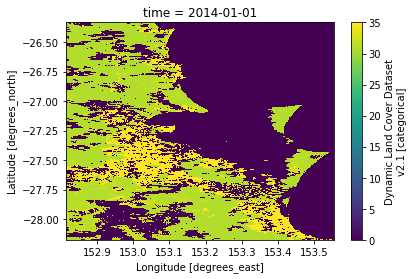

In [23]:
import matplotlib.pyplot as plt

xds['dynamic_land_cover'].sel({'time': '2014-01-01'}).plot()

The map shows a section of South-East Queensland, between Sunshine Coast and Gold Coast, with Brisbane in the middle.

The yellow values show build-up areas (value 35), 
and the pale greens show the presence of trees (values 31-34). 
The rest is zeroed out.

### Tiff Results

In [24]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('dynamic_land_cover.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  

{'meta': {'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': None,
  'width': 315,
  'height': 778,
  'count': 10,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.0023489999999999783, 0.0, 152.815223,
         0.0, 0.002364115830115831, -28.17422055791506)},
 'bounds': BoundingBox(left=152.815223, bottom=-26.334938442084944, right=153.555158, top=-28.17422055791506),
 'resolution': (0.0023489999999999783, -0.002364115830115831),
 'tags': <function DatasetReader.tags>,
 'indexes': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
 'name': 'data/outputs/dynamic_land_cover.tif',
 'mode': 'r'}

In [21]:
rds.read(1)  # show some data from the first layer

array([[31., 31., 31., ..., 33., 33.,  0.],
       [31., 31., 31., ...,  0.,  0.,  0.],
       [31., 31., 31., ..., 35.,  0., 34.],
       ...,
       [31., 31., 31., ...,  0.,  0.,  0.],
       [31., 31., 31., ...,  0.,  0.,  0.],
       [31., 31., 31., ...,  0.,  0.,  0.]])

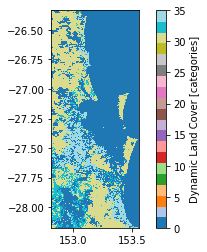

In [22]:
from matplotlib import pyplot
axs = pyplot.imshow(rds.read(1), cmap='tab20', origin='lower',
                    extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
pyplot.colorbar(label='Dynamic Land Cover [categories]')
pyplot.show()

### Processing the CSV File

In [25]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,time,dynamic_land_cover
0,-28.173039,152.816398,2005-01-01,31.0
1,-28.173039,152.816398,2006-01-01,31.0
2,-28.173039,152.816398,2007-01-01,31.0
3,-28.173039,152.816398,2008-01-01,31.0
4,-28.173039,152.816398,2009-01-01,31.0


### Metadata

The metadata file shows the input parameters used by the process.

In [26]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "categories": {
        "indices": [
            32,
            33,
            34,
            35,
            31
        ],
        "selected": {
            "32": "trees - open",
            "33": "trees - scattered",
            "34": "trees - sparse",
            "35": "built-up surface",
            "31": "trees - closed"
        }
    },
    "spatial_selection_type": "rectangular_region",
    "temporal_selection_type": "years",
    "time_selection": {
        "yrs": [
            2005,
            2014
        ]
    },
    "bounds": {
        "lat_min": -28.175,
        "lat_max": -26.335,
        "lon_min": 152.815,
        "lon_max": 153.555
    }
}


## Single Location Selection

In [27]:
processid = 'one_wps_process'
inputs = [
    ("categories", "31, 32, 33, 34, 35"), 
    ("spatial_selection_type", "single_location"),
    ("lat", "-27.784490"), ("lon", "153.261301"),
    ("time_selection_type", "years"),
    ("year_min", "2005"), ("year_max", "2014")  
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [28]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201006T0943.zip')

Execution status: PyWPS Process started
Execution status: years 8/10 (80%)
Execution status: PyWPS Process Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections. finished


In [29]:
filepath='data/outputs/out20201006T0943.zip'

### Zip Results

In [30]:
from zipfile import ZipFile

with ZipFile(filepath) as f:
    print(f.namelist())

['dynamic_land_cover.csv', 'dynamic_land_cover.png', 'metadata.json', 'result.csv', 'result.nc']


### Metadata

In [31]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "categories": {
        "indices": [
            32,
            33,
            34,
            35,
            31
        ],
        "selected": {
            "32": "trees - open",
            "33": "trees - scattered",
            "34": "trees - sparse",
            "35": "built-up surface",
            "31": "trees - closed"
        }
    },
    "spatial_selection_type": "single_location",
    "temporal_selection_type": "years",
    "time_selection": {
        "yrs": [
            2005,
            2014
        ]
    },
    "coords": {
        "lat": -27.785,
        "lon": 153.265
    }
}


### NetCDF Results

In [32]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:             (time: 10)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-01 ... 2014-01-01
    lat                 float64 -27.79
    lon                 float64 153.3
Data variables:
    dynamic_land_cover  (time) float64 0.0 34.0 34.0 34.0 ... 34.0 34.0 0.0 0.0
Attributes:
    geospatial_lat_min:         -27.785
    geospatial_lat_max:         -27.785
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         153.265
    geospatial_lon_max:         153.265
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:                    Dynamic Land Cover sliced and filtered.
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data 

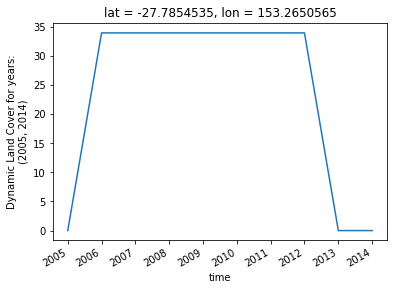

In [33]:
xds['dynamic_land_cover'].plot()

### CSV Results

In [34]:
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,time,lat,lon,dynamic_land_cover
0,2005-01-01,-27.785453,153.265056,0.0
1,2006-01-01,-27.785453,153.265056,34.0
2,2007-01-01,-27.785453,153.265056,34.0
3,2008-01-01,-27.785453,153.265056,34.0
4,2009-01-01,-27.785453,153.265056,34.0


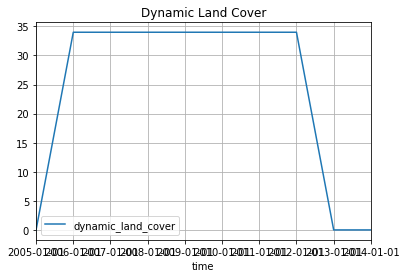

In [35]:
df.plot('time', ['dynamic_land_cover'], kind='line', title='Dynamic Land Cover', grid=True)

### Show PNG File

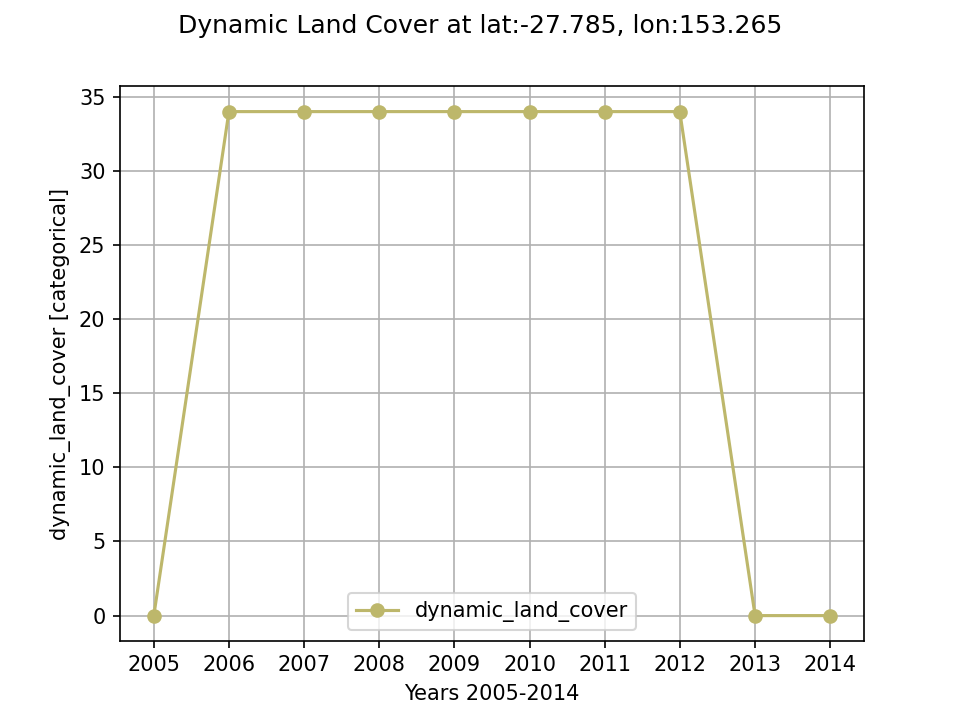

In [36]:
from IPython.display import Image, display

with ZipFile(filepath) as z:
    fp = z.extract('dynamic_land_cover.png', 'data/outputs')
    display(Image(fp, width=600, height=400)) 

### Predefined Region Selection

In [37]:
processid = 'one_wps_process'
inputs = [
    ("categories", "31, 32, 33, 34, 35"),
    ("spatial_selection_type", "predefined_region"),
    ("gdb_name", "ibra7_subregions_states"), 
    ("rec_id", "347_QLD"),
    ("time_selection_type", "one_year"),
    ("year", "2014"), 
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [38]:
monitor_execution(execution, sleepSecs=5, download=True, filepath='data/outputs/out20201006T0950.zip')

Execution status: PyWPS Process started
Execution status: one_year 2/2 completed.
Execution status: PyWPS Process Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections. finished


### Zip Results

In [47]:
filepath2='data/outputs/out20201006T0950.zip'

In [40]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['dynamic_land_cover.csv', 'result.zarr', 'dynamic_land_cover.tif', 'metadata.json', 'result.csv', 'result.nc']


### NetCDF Result

In [41]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:             (lat: 782, lon: 313, time: 1)
Coordinates:
  * lat                 (lat) float64 -28.18 -28.17 -28.17 ... -26.33 -26.33
  * lon                 (lon) float64 152.8 152.8 152.8 ... 153.5 153.5 153.6
  * time                (time) datetime64[ns] 2014-01-01
    spatial_ref         int32 0
Data variables:
    dynamic_land_cover  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    geospatial_lat_min:         -28.175
    geospatial_lat_max:         -26.331
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.819
    geospatial_lon_max:         153.552
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:                    Dynamic Land Cover sliced

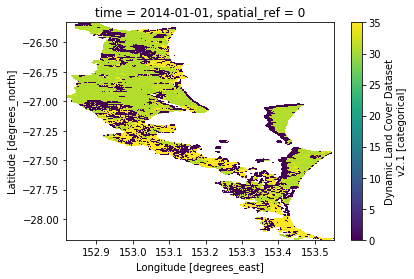

In [42]:
xds['dynamic_land_cover'].sel({'time': '2014-01-01'}).plot()

## Hand-drawn Polygon Selection¶

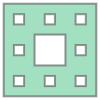

In [53]:
from shapely import wkt

with open("data/polygons/rect_holes.wkt", "r") as f:
    rect_holes_geom = wkt.loads(f.read())
rect_holes_geom 

In [54]:
rect_holes_geom.wkt[:500]

'POLYGON ((150.005 -29.005, 150.005 -27.005, 152.005 -27.005, 152.005 -29.005, 150.005 -29.005), (150.6716666666667 -28.33833333333333, 151.3383333333333 -28.33833333333333, 151.3383333333333 -27.67166666666667, 150.6716666666667 -27.67166666666667, 150.6716666666667 -28.33833333333333), (150.225 -28.785, 150.445 -28.785, 150.445 -28.565, 150.225 -28.565, 150.225 -28.785), (150.8916666666667 -28.785, 151.1116666666667 -28.785, 151.1116666666667 -28.565, 150.8916666666667 -28.565, 150.891666666666'

In [55]:
processid = 'one_wps_process'
inputs = [
    ("categories", "31, 32, 33, 34, 35"),
    ("spatial_selection_type", "polygon"),
    ("geometry", rect_holes_geom.wkt), 
    ("time_selection_type", "one_year"),
    ("year", "2014")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [56]:
monitor_execution(execution, sleepSecs=5, download=True, filepath='data/outputs/out20201006T1000.zip')

Execution status: PyWPS Process started
Execution status: one_year 4/4 completed.
Execution status: one_year 4/4 completed.
Execution status: PyWPS Process Dynamic Land Cover (dylancov) combined process for multiple spatial and time selections. finished


### Zip Contents

In [57]:
filepath='data/outputs/out20201006T1000.zip'

from zipfile import ZipFile

f = ZipFile(filepath)
print(f.namelist())
f.close()

['dynamic_land_cover.csv', 'result.zarr', 'dynamic_land_cover.tif', 'metadata.json', 'result.csv', 'result.nc']


In [59]:
import xarray as xr

with ZipFile(filepath) as z:
    res = z.extract('result.nc', path='workspace/data/outputs/')
xds = xr.load_dataset(res)
xds

<xarray.Dataset>
Dimensions:             (lat: 848, lon: 846, time: 1)
Coordinates:
  * lat                 (lat) float64 -29.0 -29.0 -29.0 ... -27.01 -27.01 -27.01
  * lon                 (lon) float64 150.0 150.0 150.0 ... 152.0 152.0 152.0
  * time                (time) datetime64[ns] 2014-01-01
    spatial_ref         int32 0
Data variables:
    dynamic_land_cover  (time, lat, lon) float64 0.0 0.0 0.0 ... 31.0 31.0 31.0
Attributes:
    geospatial_lat_min:         -29.005
    geospatial_lat_max:         -27.006
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         150.007
    geospatial_lon_max:         152.004
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    license_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ENVIRONMENT
    summary:                    Dynamic Land Cover sli

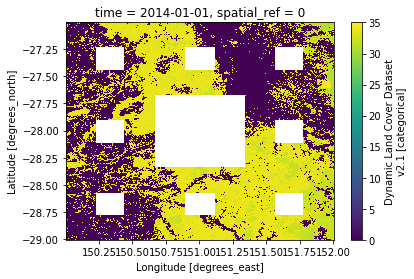

In [60]:
xds['dynamic_land_cover'].plot()